# Long Short Term Memory Network (LSTM)

## Load Libraries and Dataset

In [1]:
# Import required libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import defaultdict
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, SimpleRNN, Activation
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Flatten
from tensorflow.keras import backend as K
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from keras.models import load_model
import re

In [2]:
# Load dataset from database

db = sqlite3.connect('C:/Users/ksreni/belajar_ds/DSC_9_Kelompok 1_Challenge Platinum/database.db', check_same_thread = False)
q_data = 'SELECT * FROM data'
data = pd.read_sql_query(q_data, db)
data.head()

,Tweet,Label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k mmbri hujjah partai ap...,neutral
2,lokasi strategis di jalan sumatra bandung temp...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,aduh jadi mahasiswa jangan sombong dong kasih ...,negative


In [3]:
# Data distribution check

data['Label'].value_counts()

positive    6383
negative    3412
neutral     1138
Name: Label, dtype: int64

## Feature-Label Classification

In [4]:
# Oversampling neutral label to be equal with negative label

data_pos = data[data['Label']=='positive']
data_neu = data[data['Label']=='neutral']
data_neg = data[data['Label']=='negative']

df_neu = data_neu.sample(data_neg.shape[0], replace = True)

data = pd.concat([data_pos, df_neu, data_neg])

# Group data tweet

pos_tweet = data.loc[data['Label']=='positive'].Tweet.tolist()
neg_tweet = data.loc[data['Label']=='negative'].Tweet.tolist()
neu_tweet = data.loc[data['Label']=='neutral'].Tweet.tolist()

# Group data label

pos_label = data.loc[data['Label']=='positive'].Label.tolist()
neg_label = data.loc[data['Label']=='negative'].Label.tolist()
neu_label = data.loc[data['Label']=='neutral'].Label.tolist()

In [5]:
# Final sentiment data check

total_data = pos_tweet + neg_tweet + neu_tweet
labels = pos_label + neu_label + neg_label

print("Positive: %s, Neutral: %s, Negative: %s" % (len(pos_tweet), len(neu_tweet), len(neg_tweet)))
print("Total data: %s" % len(total_data))
print("Total labels: %s" % len(labels))

Positive: 6383, Neutral: 3412, Negative: 3412
Total data: 13207
Total labels: 13207


## Feature Extraction

In [6]:
# Tokenizer and pad sequence

max_features = 100000
tokenizer = Tokenizer(num_words=max_features, split=' ', lower=True)
tokenizer.fit_on_texts(total_data)
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("tokenizer.pickle has created!")

X = tokenizer.texts_to_sequences(total_data)

vocab_size = len(tokenizer.word_index)
maxlen = max(len(x) for x in X)

X = pad_sequences(X)
with open('x_pad_sequences.pickle', 'wb') as handle:
    pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("x_pad_sequences.pickle has created!")

tokenizer.pickle has created!
x_pad_sequences.pickle has created!


In [7]:
# Feature extraction for labels

Y = pd.get_dummies(labels)
Y = Y.values

with open('y_labels.pickle', 'wb') as handle:
    pickle.dump(Y, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("y_labels.pickle has created!")

y_labels.pickle has created!


## Train-Test Data Split

In [8]:
# Split train-test data with proportion 80:20

file = open("x_pad_sequences.pickle",'rb')
X = pickle.load(file)
file.close()

file = open("y_labels.pickle",'rb')
Y = pickle.load(file)
file.close()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

## Model Training

In [9]:
##### Model training and cross validation

kf = KFold(n_splits=5,random_state=42,shuffle=True)

accuracies = []

y = Y

embed_dim = 100
units = 64

for iteration, data in enumerate(kf.split(X), start=1):

    data_train   = X[data[0]]
    target_train = y[data[0]]

    data_test    = X[data[1]]
    target_test  = y[data[1]]
    
    # Create model architecture

    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
    model.add(LSTM(units, dropout=0.5))
    model.add(Dense(3,activation='softmax'))
    # model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])

    adam = optimizers.Adam(learning_rate = 0.0005)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
    history = model.fit(data_train, target_train, epochs=50, batch_size=32, 
                        validation_data=(data_test, target_test), verbose=1, callbacks=[es])

    predictions = model.predict(X_test)
    y_pred = predictions

    # for the current fold only
    
    accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))

    print("Training ke-", iteration)
    print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
    print("======================================================")

    accuracies.append(accuracy)

# this is the average accuracy over all folds

average_accuracy = np.mean(accuracies)

print()
print()
print()
print("Rata-rata Accuracy: ", round(average_accuracy,4))

Epoch 1/50
331/331 [==============================] - 30s 87ms/step - loss: 0.6271 - accuracy: 0.7396 - val_loss: 0.3541 - val_accuracy: 0.8785
Epoch 2/50
331/331 [==============================] - 30s 90ms/step - loss: 0.2866 - accuracy: 0.8966 - val_loss: 0.2609 - val_accuracy: 0.9016
Epoch 3/50
331/331 [==============================] - 29s 88ms/step - loss: 0.1742 - accuracy: 0.9372 - val_loss: 0.2814 - val_accuracy: 0.9042
Epoch 4/50
331/331 [==============================] - 29s 88ms/step - loss: 0.1344 - accuracy: 0.9523 - val_loss: 0.2357 - val_accuracy: 0.9111
Epoch 5/50
331/331 [==============================] - 29s 88ms/step - loss: 0.0898 - accuracy: 0.9688 - val_loss: 0.2700 - val_accuracy: 0.9008
Epoch 6/50
331/331 [==============================] - 29s 89ms/step - loss: 0.0700 - accuracy: 0.9756 - val_loss: 0.2636 - val_accuracy: 0.9035
Epoch 6: early stopping
83/83 [==============================] - 1s 9ms/step
Training ke- 1
              precision    recall  f1-score 

## Evaluation

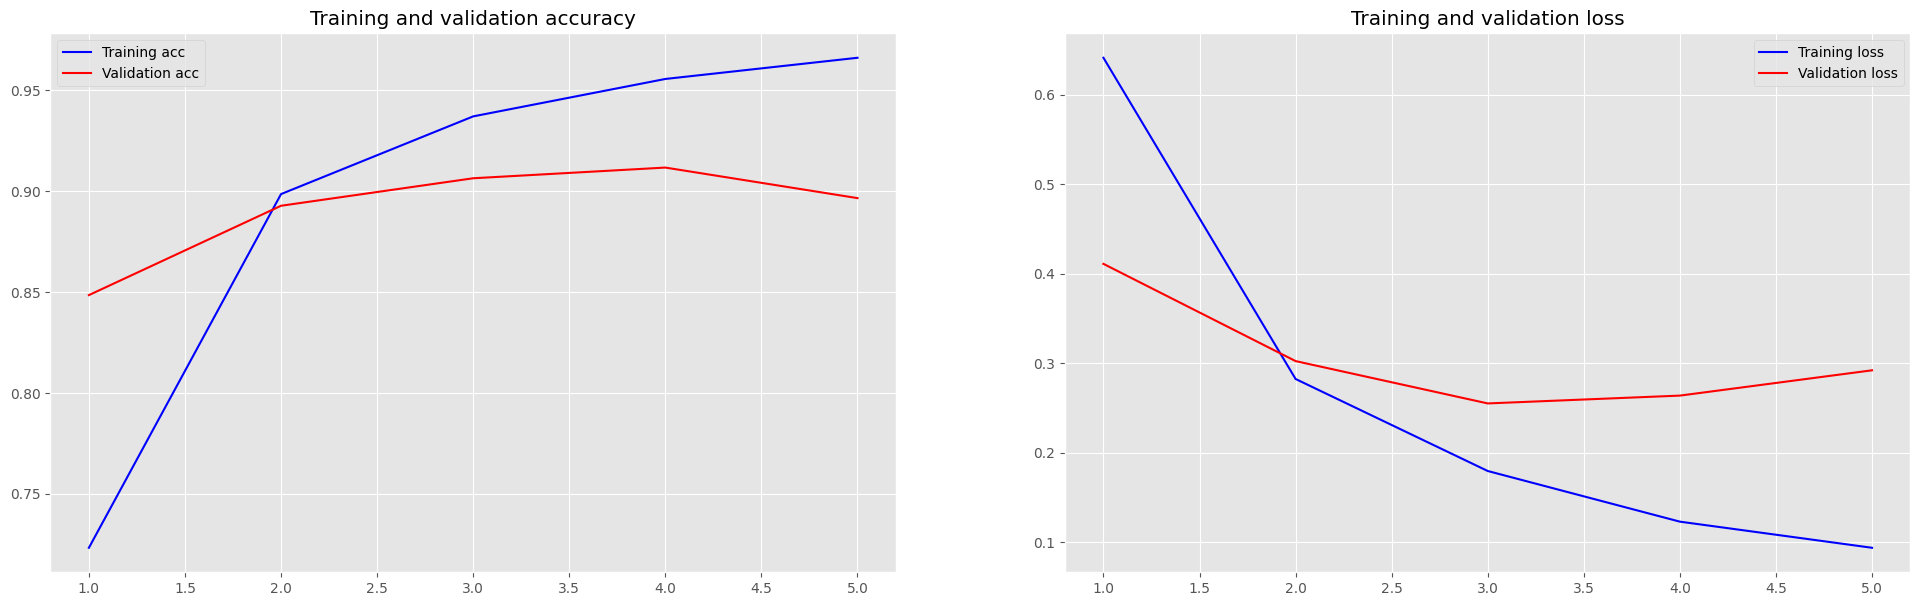

In [10]:
# Visualize it

plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(24, 7))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

%matplotlib inline
plot_history(history)

Setelah 5 kali training dengan epoch masing-masing berhenti di epoch ke 5, didapatkan rata-rata akurasi model senilai 96.1%

In [11]:
# Save the model

model.save('model.h5')
print("Model has created!")

Model has created!


C:\Users\ksreni\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Prediction

In [12]:
input_text = """
rasanya enak  """

def cleansing(sent):
    string = sent.lower()
    string = re.sub(r'[^a-zA-Z0-9]', ' ', string)
    return string

sentiment = ['negative', 'neutral', 'positive']

text = [cleansing(input_text)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('model.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])
hasil = sentiment[polarity]

print("Text: %s" % text[0])
print("Sentiment: %s" % sentiment[polarity])

1/1 [==============================] - 0s 428ms/step
Text:  rasanya enak  
Sentiment: positive


In [18]:
input_text = """
mobil butut?!  """

def cleansing(sent):
    string = sent.lower()
    string = re.sub(r'[^a-zA-Z0-9]', ' ', string)
    return string

sentiment = ['negative', 'neutral', 'positive']

text = [cleansing(input_text)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('model.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])
hasil = sentiment[polarity]

print("Text: %s" % text[0])
print("Sentiment: %s" % sentiment[polarity])

1/1 [==============================] - 0s 259ms/step
Text:  mobil butut    
Sentiment: neutral


In [16]:
input_text = """
tidak enak  """

def cleansing(sent):
    string = sent.lower()
    string = re.sub(r'[^a-zA-Z0-9]', ' ', string)
    return string

sentiment = ['negative', 'neutral', 'positive']

text = [cleansing(input_text)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('model.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])
hasil = sentiment[polarity]

print("Text: %s" % text[0])
print("Sentiment: %s" % sentiment[polarity])

1/1 [==============================] - 0s 443ms/step
Text:  tidak enak  
Sentiment: positive
